In [8]:
import os
import pandas as pd

temp_dir = 'temp_download'
# Load selected features
X_train = pd.read_csv(os.path.join(temp_dir,'X_train_res.csv'))
X_val = pd.read_csv(os.path.join(temp_dir,'X_val_selected.csv'))
X_test = pd.read_csv(os.path.join(temp_dir,'X_test_selected.csv'))

y_train = pd.read_csv(os.path.join(temp_dir, 'y_train_res.csv')).values.ravel()
y_val = pd.read_csv(os.path.join(temp_dir, 'y_val.csv')).values.ravel()
y_test = pd.read_csv(os.path.join(temp_dir, 'y_test.csv')).values.ravel()

# Load raw data for comparison

X_train_raw = pd.read_csv(os.path.join(temp_dir, 'X_train_scaled.csv'))
X_val_raw = pd.read_csv(os.path.join(temp_dir, 'X_val_scaled.csv'))

In [10]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

def objective(trial):
    # Define the search space for hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'random_state': 42,
        'eval_metric': 'logloss',
        'device': 'cuda',
        'n_jobs': -1
    }

    # Create and train the model with the suggested hyperparameters
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)

    # Evaluate the model using cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    mean_score = scores.mean()

    return mean_score

In [11]:
# Run Optuna to find the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best parameters and the best score
print('Best Parameters:', study.best_params)
print('Best ROC AUC Score:', study.best_value)

[I 2025-02-05 18:32:36,695] A new study created in memory with name: no-name-86bc9dda-bec4-4c23-9ca2-a62e2b101892
[I 2025-02-05 18:32:40,242] Trial 0 finished with value: 0.9999882241662871 and parameters: {'n_estimators': 264, 'max_depth': 4, 'learning_rate': 0.42680596772810153, 'subsample': 0.7507998774546848, 'colsample_bytree': 0.664086514338393, 'gamma': 3.6607655323182513e-07, 'min_child_weight': 3, 'reg_alpha': 0.04543969624002204, 'reg_lambda': 0.008983753168730508}. Best is trial 0 with value: 0.9999882241662871.
[I 2025-02-05 18:32:43,713] Trial 1 finished with value: 0.9999826044859693 and parameters: {'n_estimators': 210, 'max_depth': 5, 'learning_rate': 0.1597877507635305, 'subsample': 0.8950514604770761, 'colsample_bytree': 0.6106912031699274, 'gamma': 0.5999010933986714, 'min_child_weight': 4, 'reg_alpha': 1.841870747733948e-08, 'reg_lambda': 1.56035684001444e-08}. Best is trial 0 with value: 0.9999882241662871.
[I 2025-02-05 18:32:47,388] Trial 2 finished with value: 0

Best Parameters: {'n_estimators': 485, 'max_depth': 9, 'learning_rate': 0.17915393270706836, 'subsample': 0.684318016297168, 'colsample_bytree': 0.8129720176600581, 'gamma': 0.1441374096087281, 'min_child_weight': 3, 'reg_alpha': 2.3714274830498942e-05, 'reg_lambda': 3.735118313837843e-05}
Best ROC AUC Score: 0.9999914105843247


In [12]:
# Train the final model with the best parameters
best_params = study.best_params
best_model = XGBClassifier(**best_params, random_state=42, device='cuda')
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

In [13]:
print('\nClassification Report:')
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.75      0.85      0.80        98

    accuracy                           1.00     56962
   macro avg       0.88      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962



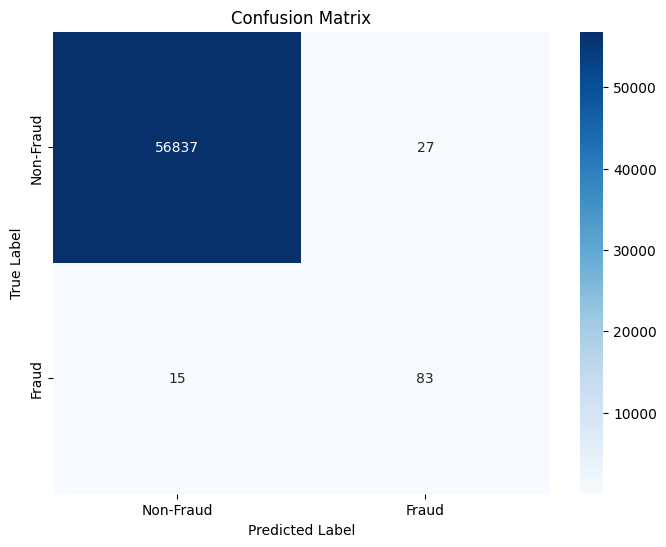

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()